In [1]:
import matplotlib.pyplot as plt
import numpy as np
import json

In [2]:
with open('benchmarking_results_1.json', 'r') as f:
    benchmark_data_list = json.load(f)

benchmark_data = {d['name']: {k: v for k, v in d.items() if k != 'name'} for d in benchmark_data_list}
benchmark_data

{'llama-wth-not_quantized': {'module': 'pipelines.llama_pipeline',
  'function': 'run_llama_pipeline',
  'args': [],
  'kwargs': {'model_path': 'llama-wth/unsloth.BF16.gguf',
   'prompt_type': 'wth'},
  'dataset_name': 'zpp-murmuras/llama-ds-wth-rev3',
  'splits': {'penny': 'penny_train+penny_test',
   'edeka': 'edeka_train+edeka_test',
   'dm': 'dm_test',
   'lidl': 'lidl_test',
   'rewe': 'rewe_test',
   'rossmann': 'rossmann_test'},
  'threshold': 0.5,
  'scores': {'penny': 0.45418996854920685,
   'edeka': 0.22346718355309075,
   'dm': 0.796804760827727,
   'lidl': 0.9231444086310769,
   'rewe': 0.9643409937491247,
   'rossmann': 0.9185477493890916},
  'expected': {'penny': 67,
   'edeka': 379,
   'dm': 1310,
   'lidl': 1478,
   'rewe': 2751,
   'rossmann': 473},
  'generated': {'penny': 52,
   'edeka': 662,
   'dm': 1541,
   'lidl': 1731,
   'rewe': 3603,
   'rossmann': 460},
  'missed': {'penny': 33,
   'edeka': 267,
   'dm': 209,
   'lidl': 99,
   'rewe': 56,
   'rossmann': 36},


In [3]:
with open('quantization_comparison/quantization_comparison_results.json', 'r') as f:
    quant_data = json.load(f)
quant_data

{'not_quantized': {'prompt_eval_rate': 3.11,
  'generation_rate': 2.0,
  'file_size': 2479591168},
 'q8_0': {'prompt_eval_rate': 12.91,
  'generation_rate': 8.53,
  'file_size': 1321078528},
 'q4_k_m': {'prompt_eval_rate': 27.79,
  'generation_rate': 12.74,
  'file_size': 807689984},
 'q4_0': {'prompt_eval_rate': 40.43,
  'generation_rate': 11.16,
  'file_size': 770924288}}

In [4]:
for experiment in benchmark_data.values():
    experiment['h/e'] = {}
    for dataset in experiment['expected'].keys():
        h = experiment['hallucinated'][dataset]
        e = experiment['expected'][dataset]
        experiment['h/e'][dataset] = h / e

benchmark_data

{'llama-wth-not_quantized': {'module': 'pipelines.llama_pipeline',
  'function': 'run_llama_pipeline',
  'args': [],
  'kwargs': {'model_path': 'llama-wth/unsloth.BF16.gguf',
   'prompt_type': 'wth'},
  'dataset_name': 'zpp-murmuras/llama-ds-wth-rev3',
  'splits': {'penny': 'penny_train+penny_test',
   'edeka': 'edeka_train+edeka_test',
   'dm': 'dm_test',
   'lidl': 'lidl_test',
   'rewe': 'rewe_test',
   'rossmann': 'rossmann_test'},
  'threshold': 0.5,
  'scores': {'penny': 0.45418996854920685,
   'edeka': 0.22346718355309075,
   'dm': 0.796804760827727,
   'lidl': 0.9231444086310769,
   'rewe': 0.9643409937491247,
   'rossmann': 0.9185477493890916},
  'expected': {'penny': 67,
   'edeka': 379,
   'dm': 1310,
   'lidl': 1478,
   'rewe': 2751,
   'rossmann': 473},
  'generated': {'penny': 52,
   'edeka': 662,
   'dm': 1541,
   'lidl': 1731,
   'rewe': 3603,
   'rossmann': 460},
  'missed': {'penny': 33,
   'edeka': 267,
   'dm': 209,
   'lidl': 99,
   'rewe': 56,
   'rossmann': 36},


In [5]:
def model_comparison_barplot(model_1_score_dict, model_2_score_dict, model_1_name, model_2_name, ylabel, filename):
    benchmarks = list(model_1_score_dict.keys())
    llama_wth_vals = [model_1_score_dict[b] for b in benchmarks]
    llama_w_vals = [model_2_score_dict[b] for b in benchmarks]

    x = np.arange(len(benchmarks))
    width = 0.35

    fig, ax = plt.subplots()
    bars1 = ax.bar(x - width/2, llama_wth_vals, width, label=model_1_name)
    bars2 = ax.bar(x + width/2, llama_w_vals, width, label=model_2_name)

    ax.set_ylabel(ylabel)
    ax.set_title(f'{model_1_name} vs {model_2_name}')
    ax.set_xticks(x)
    ax.set_xticklabels(benchmarks)
    ax.legend()

    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

# Model comparisons

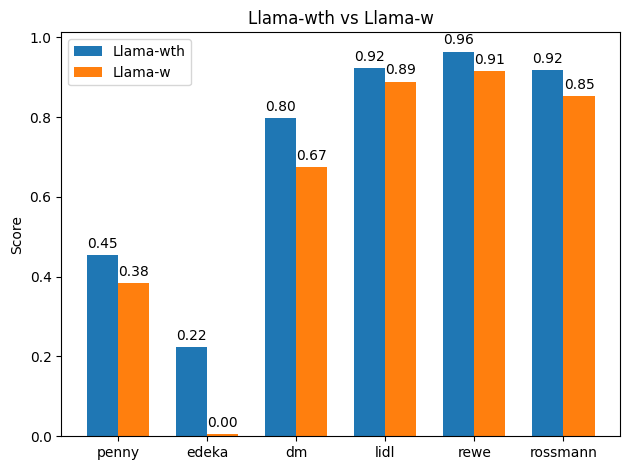

In [6]:
model_comparison_barplot(
    benchmark_data['llama-wth-not_quantized']['scores'],
    benchmark_data['llama-w-not_quantized']['scores'],
    'Llama-wth',
    'Llama-w',
    'Score',
    'llama_wth_vs_w_scores'
)

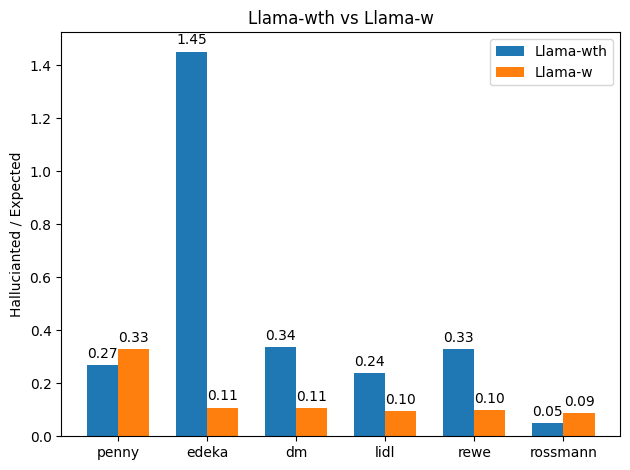

In [7]:
model_comparison_barplot(
    benchmark_data['llama-wth-not_quantized']['h/e'],
    benchmark_data['llama-w-not_quantized']['h/e'],
    'Llama-wth',
    'Llama-w',
    'Hallucianted / Expected',
    'llama_wth_vs_w_h_by_e'
)

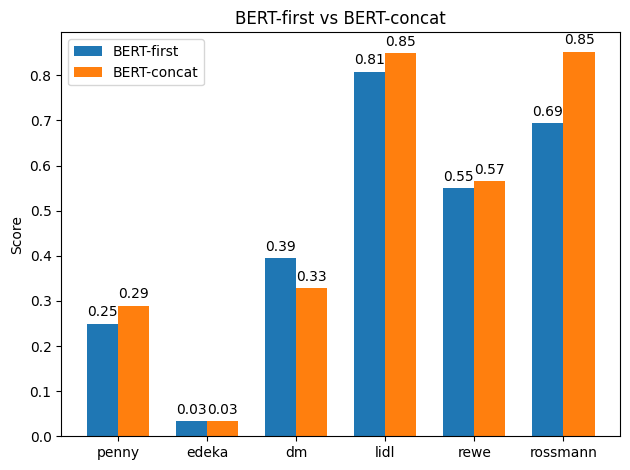

In [8]:
model_comparison_barplot(
    benchmark_data['bert-general-no-curr-first']['scores'],
    benchmark_data['bert-general-no-curr-concat']['scores'],
    'BERT-first',
    'BERT-concat',
    'Score',
    'bert_first_vs_concat_scores'
)

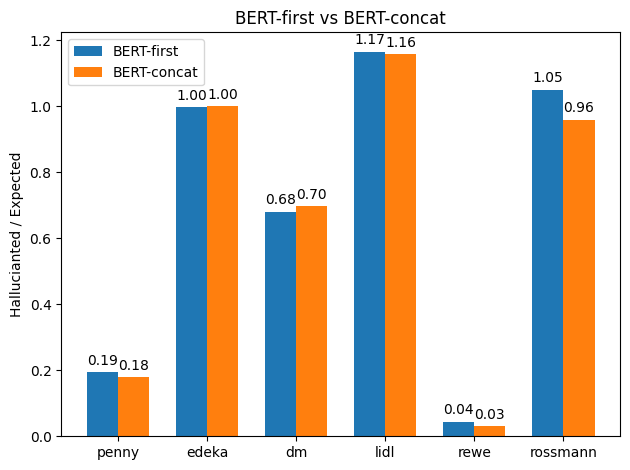

In [9]:
model_comparison_barplot(
    benchmark_data['bert-general-no-curr-first']['h/e'],
    benchmark_data['bert-general-no-curr-concat']['h/e'],
    'BERT-first',
    'BERT-concat',
    'Hallucianted / Expected',
    'bert_first_vs_concat_h_by_e'
)

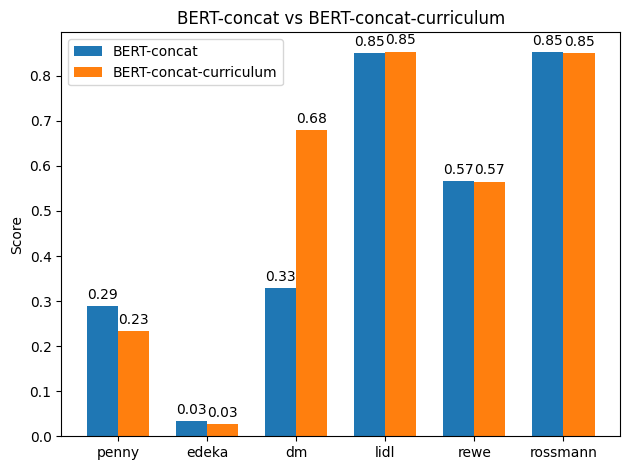

In [10]:
model_comparison_barplot(
    benchmark_data['bert-general-no-curr-concat']['scores'],
    benchmark_data['bert-general-curr-concat']['scores'],
    'BERT-concat',
    'BERT-concat-curriculum',
    'Score',
    'bert_no_curr_vs_curr_scores'
)

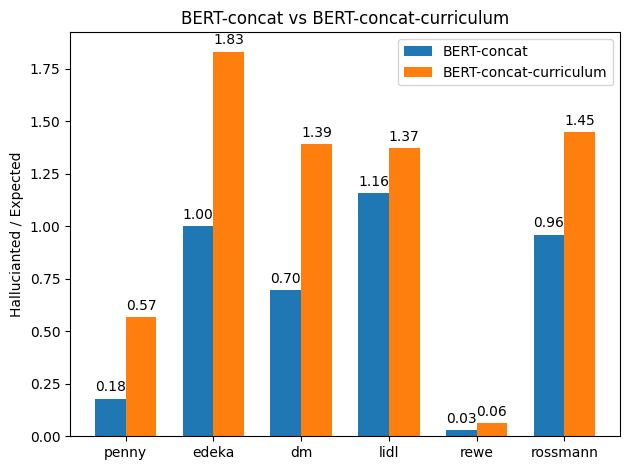

In [11]:
model_comparison_barplot(
    benchmark_data['bert-general-no-curr-concat']['h/e'],
    benchmark_data['bert-general-curr-concat']['h/e'],
    'BERT-concat',
    'BERT-concat-curriculum',
    'Hallucianted / Expected',
    'bert_no_curr_vs_curr_h_by_e'
)

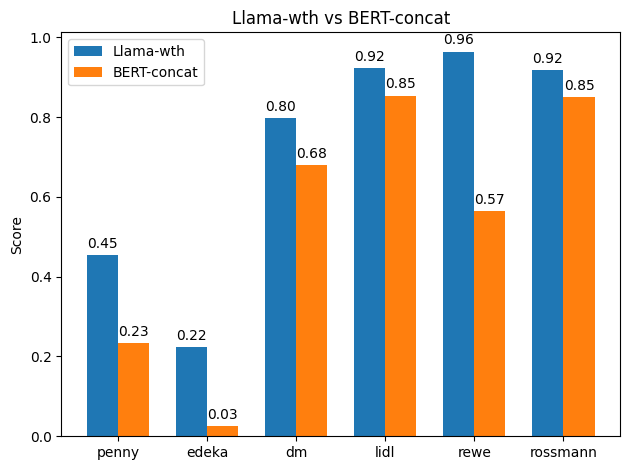

In [12]:
model_comparison_barplot(
    benchmark_data['llama-wth-not_quantized']['scores'],
    benchmark_data['bert-general-curr-concat']['scores'],
    'Llama-wth',
    'BERT-concat',
    'Score',
    'llama_vs_bert_scores'
)

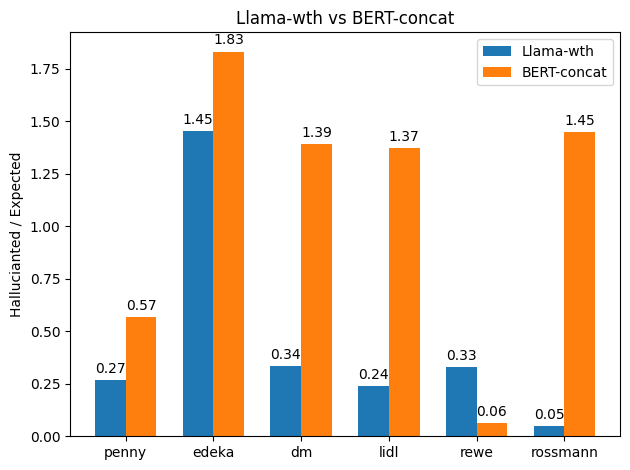

In [13]:
model_comparison_barplot(
    benchmark_data['llama-wth-not_quantized']['h/e'],
    benchmark_data['bert-general-curr-concat']['h/e'],
    'Llama-wth',
    'BERT-concat',
    'Hallucianted / Expected',
    'llama_vs_bert_h_by_e'
)

# Quantizations

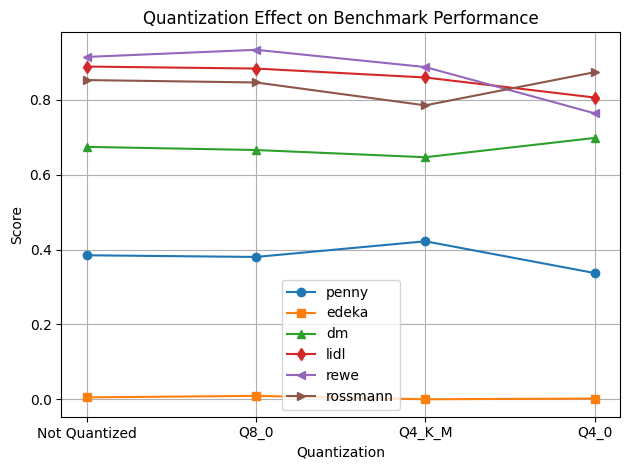

In [14]:
quantized_model_names = ['llama-w-not_quantized', 'llama-w-q8_0', 'llama-w-q4_k_m', 'llama-w-q4_0']
quantizations = ['not_quantized', 'q8_0', 'q4_k_m', 'q4_0']
quantization_labels = ['Not Quantized', 'Q8_0', 'Q4_K_M', 'Q4_0']

penny_scores = [benchmark_data[m]['scores']['penny'] for m in quantized_model_names]
edeka_scores = [benchmark_data[m]['scores']['edeka'] for m in quantized_model_names]
dm_scores = [benchmark_data[m]['scores']['dm'] for m in quantized_model_names]
lidl_scores = [benchmark_data[m]['scores']['lidl'] for m in quantized_model_names]
rewe_scores = [benchmark_data[m]['scores']['rewe'] for m in quantized_model_names]
rossmann_scores = [benchmark_data[m]['scores']['rossmann'] for m in quantized_model_names]

plt.plot(quantization_labels, penny_scores, marker='o', label='penny')
plt.plot(quantization_labels, edeka_scores, marker='s', label='edeka')
plt.plot(quantization_labels, dm_scores, marker='^', label='dm')
plt.plot(quantization_labels, lidl_scores, marker='d', label='lidl')
plt.plot(quantization_labels, rewe_scores, marker='<', label='rewe')
plt.plot(quantization_labels, rossmann_scores, marker='>', label='rossmann')

plt.title('Quantization Effect on Benchmark Performance')
plt.xlabel('Quantization')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('quantization_effect_on_benchmark_performance', dpi=300, bbox_inches='tight')
plt.show()

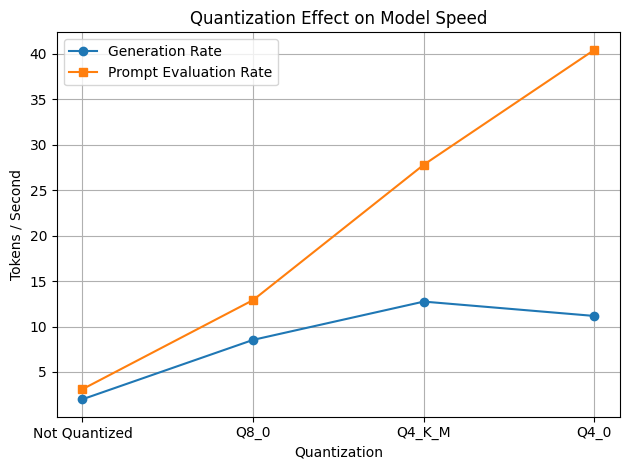

In [15]:
generation_rates = [quant_data[m]['generation_rate'] for m in quantizations]
prompt_eval_rates = [quant_data[m]['prompt_eval_rate'] for m in quantizations]

plt.plot(quantization_labels, generation_rates, marker='o', label='Generation Rate')
plt.plot(quantization_labels, prompt_eval_rates, marker='s', label='Prompt Evaluation Rate')

plt.title('Quantization Effect on Model Speed')
plt.xlabel('Quantization')
plt.ylabel('Tokens / Second')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('quantization_effect_on_model_speed', dpi=300, bbox_inches='tight')
plt.show()

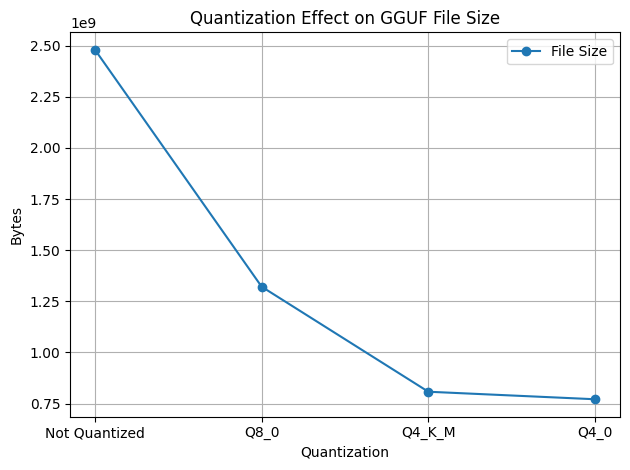

In [16]:
file_sizes = [quant_data[m]['file_size'] for m in quantizations]

plt.plot(quantization_labels, file_sizes, marker='o', label='File Size')

plt.title('Quantization Effect on GGUF File Size')
plt.xlabel('Quantization')
plt.ylabel('Bytes')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('quantization_effect_on_gguf_file_size', dpi=300, bbox_inches='tight')
plt.show()

# Appwise

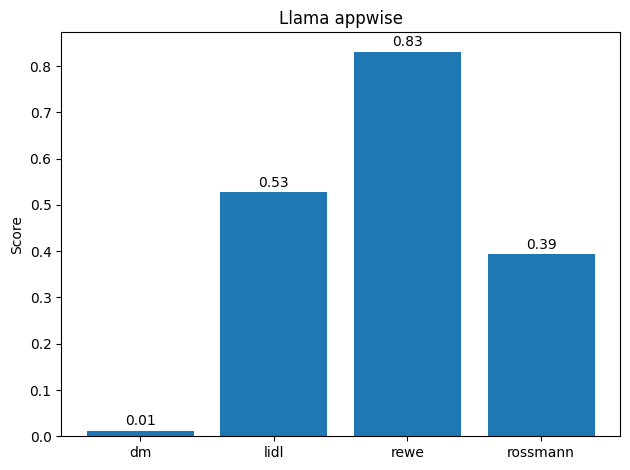

In [17]:
labels = ['dm', 
          'lidl', 
          'rewe', 
          'rossmann']
values = [benchmark_data['llama-w-appwise-dm']['scores']['dm'],
          benchmark_data['llama-w-appwise-lidl']['scores']['lidl'],
          benchmark_data['llama-w-appwise-rewe']['scores']['rewe'],
          benchmark_data['llama-w-appwise-rossmann']['scores']['rossmann']]
title = 'Llama appwise'
ylabel = 'Score'

plt.bar(labels, values)

plt.ylabel(ylabel)
plt.title(title)

for i, v in enumerate(values):
    plt.text(i, v + 0.005, f'{v:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('llama_appwise_scores', dpi=300, bbox_inches='tight')
plt.show()

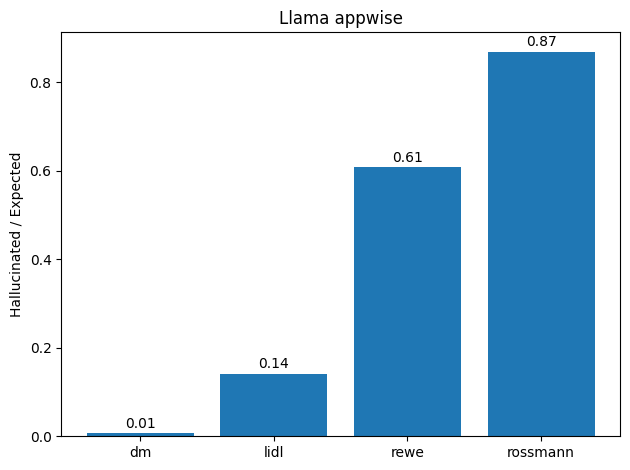

In [18]:
labels = ['dm', 
          'lidl', 
          'rewe', 
          'rossmann']
values = [benchmark_data['llama-w-appwise-dm']['h/e']['dm'],
          benchmark_data['llama-w-appwise-lidl']['h/e']['lidl'],
          benchmark_data['llama-w-appwise-rewe']['h/e']['rewe'],
          benchmark_data['llama-w-appwise-rossmann']['h/e']['rossmann']]
title = 'Llama appwise'
ylabel = 'Hallucinated / Expected'

plt.bar(labels, values)

plt.ylabel(ylabel)
plt.title(title)

for i, v in enumerate(values):
    plt.text(i, v + 0.005, f'{v:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('llama_appwise_h_by_e', dpi=300, bbox_inches='tight')
plt.show()

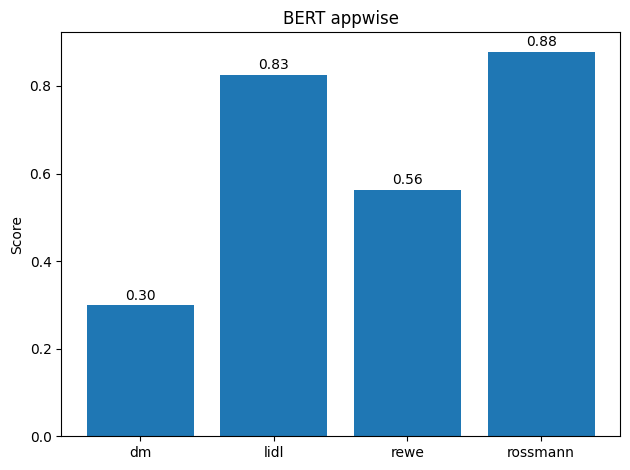

In [19]:
labels = ['dm', 
          'lidl', 
          'rewe', 
          'rossmann']
values = [benchmark_data['bert-single-app-dm']['scores']['dm'],
          benchmark_data['bert-single-app-lidl']['scores']['lidl'],
          benchmark_data['bert-single-app-rewe']['scores']['rewe'],
          benchmark_data['bert-single-app-rossmann']['scores']['rossmann']]
title = 'BERT appwise'
ylabel = 'Score'

plt.bar(labels, values)

plt.ylabel(ylabel)
plt.title(title)

for i, v in enumerate(values):
    plt.text(i, v + 0.005, f'{v:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('bert_appwise_scores', dpi=300, bbox_inches='tight')
plt.show()

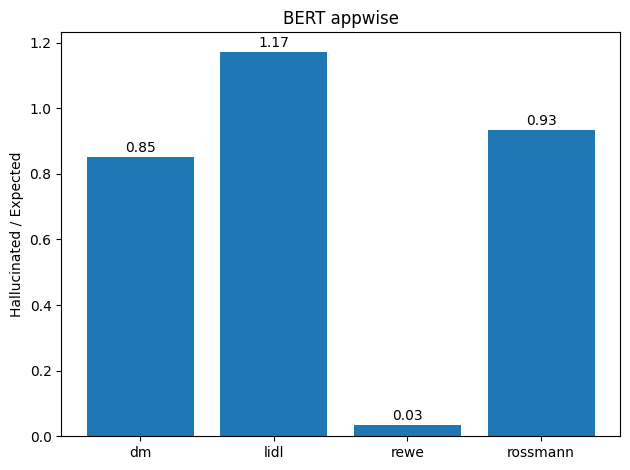

In [20]:
labels = ['dm', 
          'lidl', 
          'rewe', 
          'rossmann']
values = [benchmark_data['bert-single-app-dm']['h/e']['dm'],
          benchmark_data['bert-single-app-lidl']['h/e']['lidl'],
          benchmark_data['bert-single-app-rewe']['h/e']['rewe'],
          benchmark_data['bert-single-app-rossmann']['h/e']['rossmann']]
title = 'BERT appwise'
ylabel = 'Hallucinated / Expected'

plt.bar(labels, values)

plt.ylabel(ylabel)
plt.title(title)

for i, v in enumerate(values):
    plt.text(i, v + 0.005, f'{v:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('bert_appwise_h_by_e', dpi=300, bbox_inches='tight')
plt.show()